In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
# from torchvision import models
from torchsummary import summary
import PIL
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import random
import pandas as pd
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from pathlib import Path
from collections import defaultdict
from tqdm.notebook import tqdm



In [26]:
PIL.Image.MAX_IMAGE_PIXELS = 933120000
# IMAGE_INPUT_SIZE = (2048, 2048)
IMAGE_INPUT_SIZE = (256, 256)

In [27]:
def create_dir_if_not_exist(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)

In [131]:
DATASET_PATH = "dataset"
TRAIN_IMAGE_FOLDER = "train_images_compressed_80"
TEST_IMAGE_FOLDER = "test_images_compressed_80"

LOCAL_DATASET_DIR = "./dataset"

MODEL_DIR = "./model/"

EXPERIMENT_NAME = "exp_1"
MODEL_SAVE_DIR = Path(MODEL_DIR, EXPERIMENT_NAME)
RESULT_DIR = Path("./result", EXPERIMENT_NAME)



In [29]:
create_dir_if_not_exist(LOCAL_DATASET_DIR)

In [30]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [31]:
#show Pahtlib  combine two path example
# print(Path(DATASET_PATH) / "train")


In [32]:
#pandas load data from csv
train_csv = pd.read_csv(Path(DATASET_PATH) / 'train.csv').to_numpy()
test_csv = pd.read_csv(Path(DATASET_PATH) / 'test.csv').to_numpy()


# load npy
all_labels = np.load(Path(DATASET_PATH) / 'all_labels.npy')



In [33]:
# print(train_csv.shape)
# print(test_csv.shape)
# print(all_labels.shape)

In [34]:
dict_id_to_label = {i: label for i, label in enumerate(all_labels)}
dict_label_to_id = {label: i for i, label in enumerate(all_labels)}

In [55]:
def tran_csv_to_img_path_and_label(x_csv, data_path, image_folder, dict_label_to_id):
    x_data = []
    for i in range(len(x_csv)):
        #get img path
        img_name = str(x_csv[i][0]) + ".jpg"
        img_path = Path(data_path)  / image_folder / img_name
        # check image is exist
        if not img_path.exists():
            continue

        x_data.append([img_path, dict_label_to_id[x_csv[i][1]]])
    return x_data

In [56]:
# def tran_csv_to_data(x_csv, data_path, image_folder, dict_label_to_id):
#     x_data = []
#     for i in range(len(x_csv)):
#         #get img path
#         img_name = str(x_csv[i][0]) + ".jpg"
#         img_path = Path(data_path)  / image_folder / img_name
#         # check image is exist
#         if not img_path.exists():
#             continue
#         #load image
#         img = Image.open(img_path)

#         x_data.append([img, dict_label_to_id[x_csv[i][1]]])
#     return x_data

In [57]:
# train_data = tran_csv_to_data(train_csv, DATASET_PATH, TRAIN_IMAGE_FOLDER, dict_label_to_id)
# test_data = tran_csv_to_data(test_csv, DATASET_PATH, TEST_IMAGE_FOLDER, dict_label_to_id)

train_image_path_and_label = tran_csv_to_img_path_and_label(train_csv, DATASET_PATH, TRAIN_IMAGE_FOLDER, dict_label_to_id)
test_image_path_and_label = tran_csv_to_img_path_and_label(test_csv, DATASET_PATH, TEST_IMAGE_FOLDER, dict_label_to_id)

# Random split
train_set, valid_set = train_test_split(train_image_path_and_label, test_size=0.2, random_state=42)
test_set = test_image_path_and_label


print("train set size:", len(train_set))    
print("valid set size:", len(valid_set))
print("test set size:", len(test_set))


train set size: 8
valid set size: 2
test set size: 1


(20000, 16225) <class 'PIL.JpegImagePlugin.JpegImageFile'>
(256, 256) <class 'PIL.Image.Image'>
torch.Size([3, 256, 256])


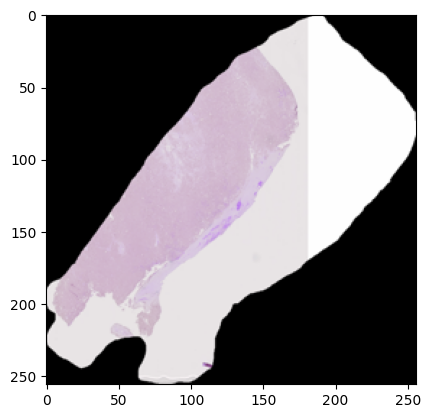

In [70]:
x = Image.open(train_set[0][0])
plt.imshow(x.resize(IMAGE_INPUT_SIZE))
# plt.imshow(x.resize((1024, 1024)))
print(x.size, type(x))
x = transforms.Resize(IMAGE_INPUT_SIZE)(x)
print(x.size, type(x))
x = transforms.ToTensor()(x)
print(x.shape)
# x.save("test.jpg")


In [37]:
# print(train_data)
# print(len(train_data))
# for img, label_id in train_data:
#     print(img.size)
#     print(label_id)
#     img_down = img.resize((224, 224))
#     plt.imshow(img_down)

#     # # Image to numpy
#     # img_down = np.array(img_down)
#     # # torch downsample to 80*80
#     # img_down = torch.from_numpy(img_down).float()
#     # img_down = img_down.permute(2, 0, 1)
#     # # torch downsample to 80*80
#     # img_down = F.interpolate(img_down.unsqueeze(0), size=80, mode="bilinear", align_corners=False).squeeze(0)

#     # # plot img_down
#     # plt.imshow(img_down.permute(1, 2, 0).numpy().astype(np.uint8))
#     break

In [38]:
# from torchvision.io import read_image

# class UBCDataset(Dataset):
#     def __init__(self, data, transform=None, target_transform=None):
#         self.data = data
#         self.transform = transform
#         self.target_transform = target_transform

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         # image = read_image(img_path)
#         image, label = self.data[idx]
#         # print(np.max(image), np.min(image))
#         if self.transform:
#             image = self.transform(image)
#         if self.target_transform:
#             label = self.target_transform(label)
#         # print(torch.max(image), torch.min(image))
#         return image, label


In [60]:
from torchvision.io import read_image

class UBCDataset(Dataset):
    def __init__(self, img_path_and_label, transform=None, target_transform=None):
        self.data = img_path_and_label
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # image = read_image(img_path)
        image_path, label = self.data[idx]
        image = Image.open(image_path)
        # print(np.max(image), np.min(image))
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        # print(torch.max(image), torch.min(image))
        return image, label


In [39]:
# # put data into UBCDataset
# train_dataset = UBCDataset(train_set, transform=transforms.ToTensor())
# valid_dataset = UBCDataset(valid_set, transform=transforms.ToTensor())
# test_dataset = UBCDataset(test_set, transform=transforms.ToTensor())


In [61]:
# put data into dataloader
train_transform = transforms.Compose([
    transforms.Resize(IMAGE_INPUT_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.Resize(IMAGE_INPUT_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = UBCDataset(train_set, transform=train_transform)
valid_dataset = UBCDataset(valid_set, transform=test_transform)
test_dataset = UBCDataset(test_set, transform=test_transform)



In [62]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

In [57]:
# for x in train_set:
#     #transform x into numpy
#     x = np.array(x[0])
#     #transform x into torch
#     x = torch.from_numpy(x).float()
#     print(x.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0, 4, 0, 1, 0, 3, 0, 3])
torch.Size([8, 3, 256, 256])


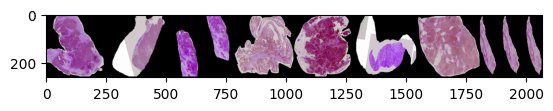

In [67]:
for imgs, labels in train_dataloader:
    break
print(labels)
print(imgs.shape)
image_grid = torchvision.utils.make_grid(imgs, nrow=8)
plt.imshow(image_grid.permute(1, 2, 0).numpy())

In [89]:
class UBC_CNN_MODEL(nn.Module):
    """
      Feel free to experiment on CNN model.
      You only need to report the model that has the best performance on the dataset.
    """

    def __init__(self, output_dim=5):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 16, 3, padding="same")
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding="same")
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 16, 3, padding="same")
        self.bn3 = nn.BatchNorm2d(16)

        self.conv4 = nn.Conv2d(16, 32, 3, padding="same")
        self.bn4 = nn.BatchNorm2d(32)

        self.conv5 = nn.Conv2d(32, 16, 3, padding="same")
        self.bn5 = nn.BatchNorm2d(16)

        self.conv6 = nn.Conv2d(16, 16, 3, padding="same")
        self.bn6 = nn.BatchNorm2d(16)
        
        self.conv7 = nn.Conv2d(16, 16, 3, padding="same")
        self.bn7 = nn.BatchNorm2d(16)
        
        self.conv8 = nn.Conv2d(16, 16, 3, padding="same")
        self.bn8 = nn.BatchNorm2d(16)


        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(int(32/2)*16*16,64) 
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_dim)

        self.first_pass = True

    def forward(self, x):
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x1 = self.relu(x1)
        x1 = self.maxpool(x1)

        x2 = self.conv2(x1)
        x2 = self.bn2(x2)
        x2 = self.relu(x2)
        x2 = self.maxpool(x2)

        x2 = self.conv3(x2)
        x2 = self.bn3(x2)
        x2 = self.relu(x2)
        # x2 = self.maxpool(x2)
        
        # x2 = self.conv4(x2)
        # x2 = self.bn4(x2)
        # x2 = self.relu(x2)
        # x2 = self.maxpool(x2)
        
        # x2 = self.conv5(x2)
        # x2 = self.bn5(x2)
        # x2 = self.relu(x2)
        # x2 = self.maxpool(x2)
        
        # x2 = self.conv6(x2)
        # x2 = self.bn6(x2)
        # x2 = self.relu(x2)
        # x2 = self.maxpool(x2)

        # x2 = self.conv7(x2)
        # x2 = self.bn7(x2)
        # x2 = self.relu(x2)
        # x2 = self.maxpool(x2)

        # x2 = self.conv8(x2)
        # x2 = self.bn8(x2)
        # x2 = self.relu(x2)


        x3 = self.maxpool(x2)
        x4 = torch.flatten(x3, 1)
        # print(x4.shape)
        if(self.first_pass == True):
            self.fc1 = nn.Linear(x4.shape[1],64).to(x4.get_device())
        x4 = self.fc1(x4)
        x4 = self.relu(x4)
        x4 = self.fc2(x4)
        x4 = self.relu(x4)
        x4 = self.fc3(x4)

        self.first_pass = False
        
        return x4


In [90]:
ubc_cnn_model = UBC_CNN_MODEL(output_dim=5).to(device)

In [91]:
summary(ubc_cnn_model, (3, ) + IMAGE_INPUT_SIZE, device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             448
       BatchNorm2d-2         [-1, 16, 256, 256]              32
              ReLU-3         [-1, 16, 256, 256]               0
         MaxPool2d-4         [-1, 16, 128, 128]               0
            Conv2d-5         [-1, 32, 128, 128]           4,640
       BatchNorm2d-6         [-1, 32, 128, 128]              64
              ReLU-7         [-1, 32, 128, 128]               0
         MaxPool2d-8           [-1, 32, 64, 64]               0
            Conv2d-9           [-1, 16, 64, 64]           4,624
      BatchNorm2d-10           [-1, 16, 64, 64]              32
             ReLU-11           [-1, 16, 64, 64]               0
        MaxPool2d-12           [-1, 16, 32, 32]               0
             ReLU-13                   [-1, 64]               0
           Linear-14                   

In [92]:
lr = 0.001
# momentum = 0.9
weight_decay = 0.0001
num_epochs = 20
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(ubc_cnn_model.parameters(), lr=lr, weight_decay=weight_decay)



In [93]:
def eval(model, valid_dataloader, criteria, device):
        model.eval()
        valid_loss = 0.0
        valid_corrects = 0

        for imgs, labels in tqdm(valid_dataloader):
            imgs = imgs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(imgs)
                _, preds = torch.max(outputs, -1)
                loss = criteria(outputs, labels)

            valid_loss += loss.item() * imgs.size(0)
            valid_corrects += torch.sum(preds == labels.data).detach().cpu().numpy()

        valid_loss = valid_loss / len(valid_dataloader.dataset)
        valid_acc = valid_corrects.double() / len(valid_dataloader.dataset)

        return valid_loss, valid_acc

In [94]:
def train(model, train_dataloader, valid_dataloader, optimizer, criteria, num_epochs, device):
    train_loss_list = []
    train_acc_list = []
    valid_loss_list = []
    valid_acc_list = []

    best_valid_loss = float('inf')
    best_valid_acc = 0.0
    best_model_valid_loss = None
    best_model_valid_acc = None

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        model.train()
        train_loss = 0.0
        train_corrects = 0

        for imgs, labels in tqdm(train_dataloader):
            imgs = imgs.to(device)
            labels = labels.to(device)


            outputs = model(imgs)
            _, preds = torch.max(outputs, -1)
            loss = criteria(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * imgs.size(0)
            train_corrects += torch.sum(preds == labels.data).detach().cpu().numpy()

        train_loss = train_loss / len(train_dataloader.dataset)
        train_acc = train_corrects.double() / len(train_dataloader.dataset)
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)

        print(f'Train loss: {train_loss:.4f} Acc: {train_acc:.4f}')

        valid_loss, valid_acc = eval(model, valid_dataloader, criteria, device)

        valid_loss_list.append(valid_loss)
        valid_acc_list.append(valid_acc)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_model_valid_loss = copy.deepcopy(model)
        
        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
            best_model_valid_acc = copy.deepcopy(model)

        print(f'Valid loss: {valid_loss:.4f} Acc: {valid_acc:.4f}')

    return model, best_model_valid_acc, best_model_valid_loss, \
           train_loss_list, train_acc_list, valid_loss_list, valid_acc_list

In [ ]:
def store_result(best_model_valid_acc, best_model_valid_loss, train_loss_list, train_acc_list, valid_loss_list, valid_acc_list):
    create_dir_if_not_exist(MODEL_SAVE_DIR)
    create_dir_if_not_exist(RESULT_DIR)

    torch.save(best_model_valid_acc.state_dict(), Path(MODEL_SAVE_DIR) / "best_model_valid_acc.pth")
    torch.save(best_model_valid_loss.state_dict(), Path(MODEL_SAVE_DIR) / "best_model_valid_loss.pth")

    with open(Path(RESULT_DIR) / "train_loss_list.pkl", "wb") as f:
        pickle.dump(train_loss_list, f)
    with open(Path(RESULT_DIR) / "train_acc_list.pkl", "wb") as f:
        pickle.dump(train_acc_list, f)
    with open(Path(RESULT_DIR) / "valid_loss_list.pkl", "wb") as f:
        pickle.dump(valid_loss_list, f)
    with open(Path(RESULT_DIR) / "valid_acc_list.pkl", "wb") as f:
        pickle.dump(valid_acc_list, f)


In [ ]:
def plot_train_eval_result(train_loss_list, train_acc_list, valid_loss_list, valid_acc_list):
    epochs = np.arange(1, len(train_loss_list) + 1)

    plt.figure(figsize=(10, 4))
    plt.subplot(2, 1, 1)
    plt.plot(epochs, train_loss_list, label='train')
    plt.plot(epochs, valid_loss_list, label='valid')
    plt.title('Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.subplot(2, 1, 2)
    plt.plot(epochs, [x*100 for x in train_acc_list], label='train')
    plt.plot(epochs, [x*100 for x in valid_acc_list], label='valid')
    plt.title('Accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    
    plt.tight_layout()

In [95]:
model_trained, best_model_valid_acc, best_model_valid_loss, \
train_loss_list, train_acc_list, valid_loss_list, valid_acc_list = \
train(ubc_cnn_model, train_dataloader, valid_dataloader, optimizer, criteria, num_epochs, device)



Epoch 1/20
----------


  0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 1.6179 Acc: 0.1250


  0%|          | 0/1 [00:00<?, ?it/s]

Valid loss: 1.5666 Acc: 0.5000
Epoch 2/20
----------


  0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 1.4833 Acc: 0.5000


  0%|          | 0/1 [00:00<?, ?it/s]

Valid loss: 1.5827 Acc: 0.0000
Epoch 3/20
----------


  0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 1.0466 Acc: 0.5000


  0%|          | 0/1 [00:00<?, ?it/s]

Valid loss: 1.4972 Acc: 0.5000
Epoch 4/20
----------


  0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 1.0327 Acc: 0.6250


  0%|          | 0/1 [00:00<?, ?it/s]

Valid loss: 1.4583 Acc: 0.5000
Epoch 5/20
----------


  0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.7198 Acc: 0.6250


  0%|          | 0/1 [00:00<?, ?it/s]

Valid loss: 1.4593 Acc: 0.5000
Epoch 6/20
----------


  0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.4996 Acc: 0.7500


  0%|          | 0/1 [00:00<?, ?it/s]

Valid loss: 1.4120 Acc: 0.5000
Epoch 7/20
----------


  0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.3162 Acc: 0.8750


  0%|          | 0/1 [00:00<?, ?it/s]

Valid loss: 1.3671 Acc: 0.5000
Epoch 8/20
----------


  0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.2992 Acc: 0.8750


  0%|          | 0/1 [00:00<?, ?it/s]

Valid loss: 1.2607 Acc: 0.5000
Epoch 9/20
----------


  0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.0787 Acc: 1.0000


  0%|          | 0/1 [00:00<?, ?it/s]

Valid loss: 1.1679 Acc: 0.5000
Epoch 10/20
----------


  0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.4093 Acc: 0.7500


  0%|          | 0/1 [00:00<?, ?it/s]

Valid loss: 1.0932 Acc: 0.5000
Epoch 11/20
----------


  0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.1137 Acc: 1.0000


  0%|          | 0/1 [00:00<?, ?it/s]

Valid loss: 1.0314 Acc: 0.5000
Epoch 12/20
----------


  0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.2097 Acc: 0.8750


  0%|          | 0/1 [00:00<?, ?it/s]

Valid loss: 0.9582 Acc: 0.5000
Epoch 13/20
----------


  0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.1071 Acc: 1.0000


  0%|          | 0/1 [00:00<?, ?it/s]

Valid loss: 0.9206 Acc: 0.5000
Epoch 14/20
----------


  0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.0467 Acc: 1.0000


  0%|          | 0/1 [00:00<?, ?it/s]

Valid loss: 0.9597 Acc: 0.5000
Epoch 15/20
----------


  0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.2525 Acc: 0.8750


  0%|          | 0/1 [00:00<?, ?it/s]

Valid loss: 1.2048 Acc: 0.5000
Epoch 16/20
----------


  0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.0875 Acc: 1.0000


  0%|          | 0/1 [00:00<?, ?it/s]

Valid loss: 1.4785 Acc: 0.5000
Epoch 17/20
----------


  0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.0402 Acc: 1.0000


  0%|          | 0/1 [00:00<?, ?it/s]

Valid loss: 1.7779 Acc: 0.5000
Epoch 18/20
----------


  0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.0722 Acc: 1.0000


  0%|          | 0/1 [00:00<?, ?it/s]

Valid loss: 1.9703 Acc: 0.5000
Epoch 19/20
----------


  0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.0315 Acc: 1.0000


  0%|          | 0/1 [00:00<?, ?it/s]

Valid loss: 2.1727 Acc: 0.5000
Epoch 20/20
----------


  0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.0226 Acc: 1.0000


  0%|          | 0/1 [00:00<?, ?it/s]

Valid loss: 2.3057 Acc: 0.5000


In [105]:
# # train_loss_list = [data.cpu().item() for data in train_loss_list]
# train_acc_list = [data.cpu().item() for data in train_acc_list]
# # valid_loss_list = [data.cpu().item() for data in valid_loss_list]
# valid_acc_list = [data.cpu().item() for data in valid_acc_list]

In [138]:
store_result(best_model_valid_acc, best_model_valid_loss, train_loss_list, train_acc_list, valid_loss_list, valid_acc_list)

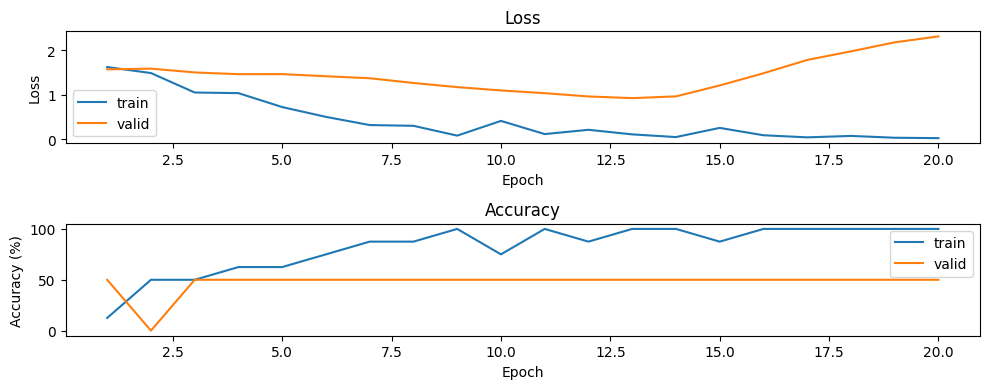

In [136]:
plot_train_eval_result(train_loss_list, train_acc_list, valid_loss_list, valid_acc_list)

In [ ]:
# efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
# utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

# efficientnet.eval().to(device)


In [ ]:
# # Download an example image
# import urllib
# url, filename = ("https://github.com/mateuszbuda/brain-segmentation-pytorch/raw/master/assets/TCGA_CS_4944.png", "TCGA_CS_4944.png")
# try: urllib.URLopener().retrieve(url, filename)
# except: urllib.request.urlretrieve(url, filename)


In [ ]:
# model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
#     in_channels=3, out_channels=1, init_features=32, pretrained=True)


In [ ]:
# import numpy as np
# from PIL import Image
# from torchvision import transforms

# input_image = Image.open(filename)
# m, s = np.mean(input_image, axis=(0, 1)), np.std(input_image, axis=(0, 1))
# preprocess = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=m, std=s),
# ])
# input_tensor = preprocess(input_image)
# input_batch = input_tensor.unsqueeze(0)

# if torch.cuda.is_available():
#     input_batch = input_batch.to('cuda')
#     model = model.to('cuda')

# with torch.no_grad():
#     output = model(input_batch)

# print(torch.round(output[0]))